In [1]:
import sys
sys.path.append('../')

import typing as tp
from pathlib import Path, PosixPath

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.data.utils import read_image, imshow
from src.data.convolution import convolve, convolve_tensors
from src.deconv.classic.wiener import wiener_rgb, wiener_gray
from src.deconv.neural.usrnet.predictor import USRNetPredictor
from src.metrics import psnr, ssim, mse, rmse

plt.gray()

<Figure size 640x480 with 0 Axes>

In [2]:
image = read_image('../datasets/gt/BSDS300/2092.jpg')
psf = np.load('../datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy', allow_pickle=True).item()['psf']
mu = 0
sigma = 0.02

# numpy array
blurred = convolve(image, psf)
noised_blurred = blurred + (sigma * np.random.randn(*blurred.shape) + mu)

# torch tensors
blurred_tensor = convolve_tensors(image, psf).cpu()
noised_blurred_tensor = blurred_tensor + (sigma * torch.randn(*blurred_tensor.shape) + mu)

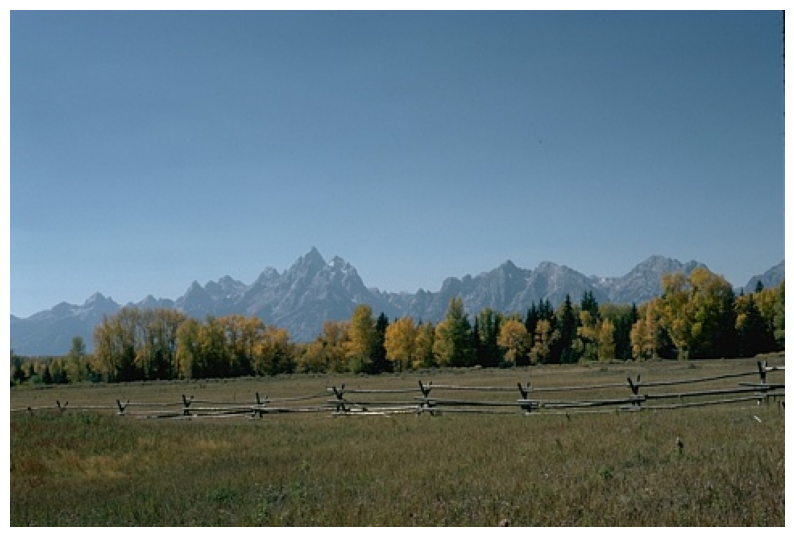

In [7]:
imshow(image, figsize=(10, 10))

In [3]:
def viz_res(
    psf: np.array, sharp_image: np.array, blurred_image: np.array, restored_image: np.array,
):
    """Vizualize results of deconvolution"""
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))

    axs[0].imshow(psf)
    axs[0].axis('off')
    axs[0].set_title('PSF')

    axs[1].imshow(blurred_image)
    axs[1].axis('off')
    axs[1].set_title('Blurred')

    axs[2].imshow(sharp_image)
    axs[2].axis('off')
    axs[2].set_title('Sharp')

    axs[3].imshow(restored_image)
    axs[3].axis('off')
    axs[3].set_title('Restored')

    plt.show()

# 1 Wiener (noise non-blind)

### Without noise

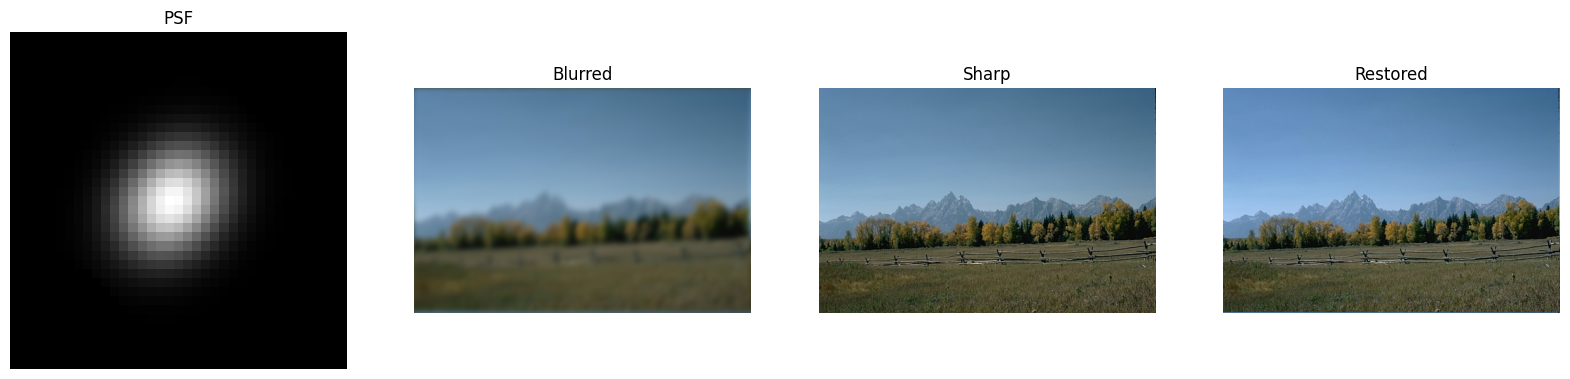

SSIM:  0.7655992
PSNR:  22.512980361468955
MSE:  0.005606630869261792


In [4]:
restored = wiener_rgb(blurred, psf, balance=0, clip=True)

viz_res(psf=psf, sharp_image=image, blurred_image=blurred, restored_image=restored)

print('SSIM: ', ssim(image, restored, channel_axis=2))
print('PSNR: ', psnr(image, restored))
print('MSE: ', mse(image, restored))

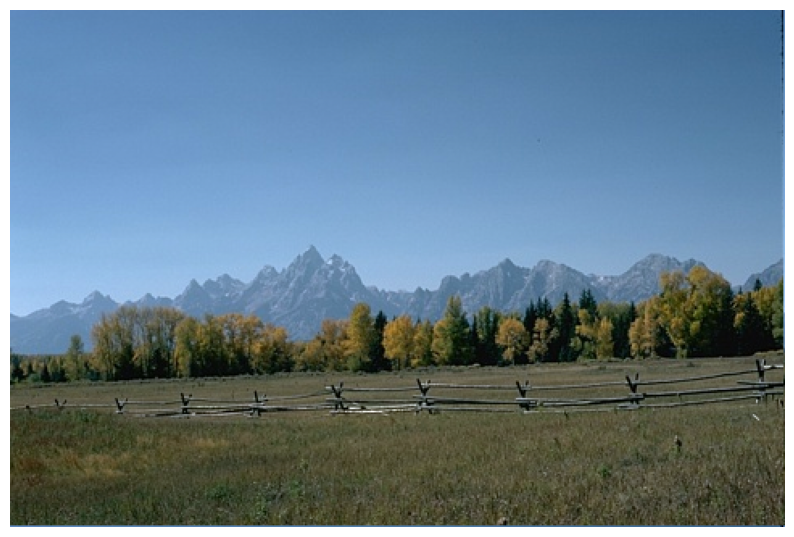

In [5]:
imshow(restored, figsize=(10, 10))

### With noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


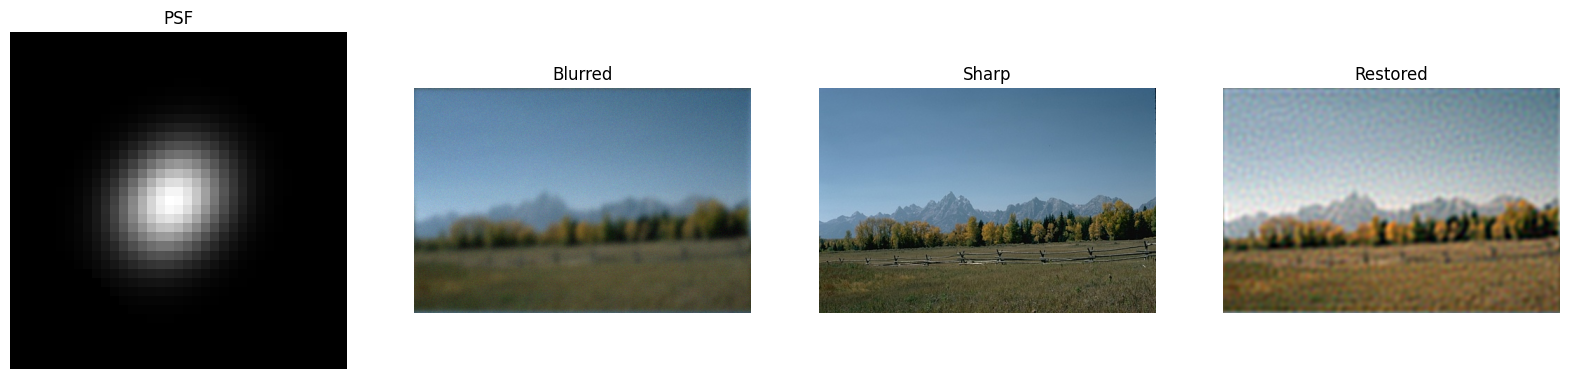

/home/chaganovaob/anaconda3/envs/deconv-venv/lib/python3.10/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM:  0.7635934
PSNR:  17.20626413665081
MSE:  0.019027143182649503


/home/chaganovaob/edu/non-blind-deconvolution-benchmark/notebooks/../src/metrics.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return peak_signal_noise_ratio(image1, image2, **psnr_params)


In [11]:
restored = wiener_rgb(noised_blurred, psf, balance=1e-1, clip=True)

viz_res(psf=psf, sharp_image=image, blurred_image=noised_blurred, restored_image=restored)

print('SSIM: ', ssim(image, restored, channel_axis=2))
print('PSNR: ', psnr(image, restored))
print('MSE: ', mse(image, restored))

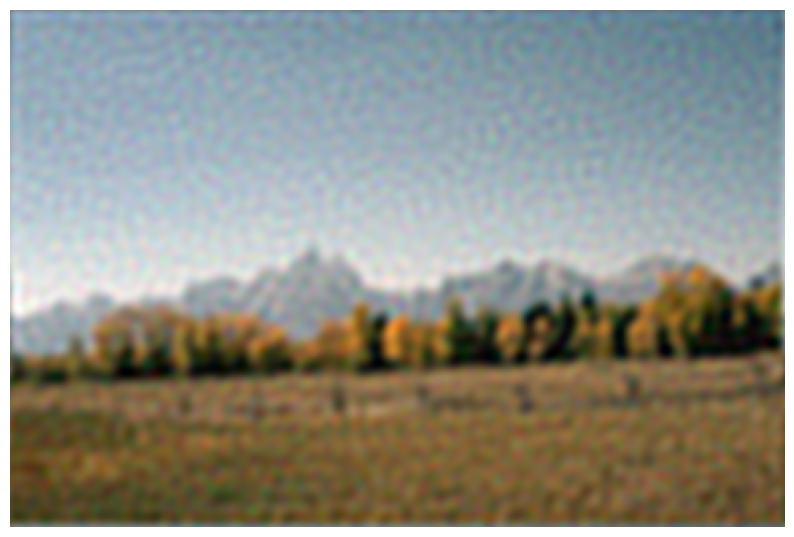

In [12]:
imshow(restored, figsize=(10, 10))

# 2 USRNet

In [13]:
model = USRNetPredictor(
    model_path='../models/usrnet.pth',
    scale_factor=1,
    noise_level=0,
    device='cpu',
)

### Without noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


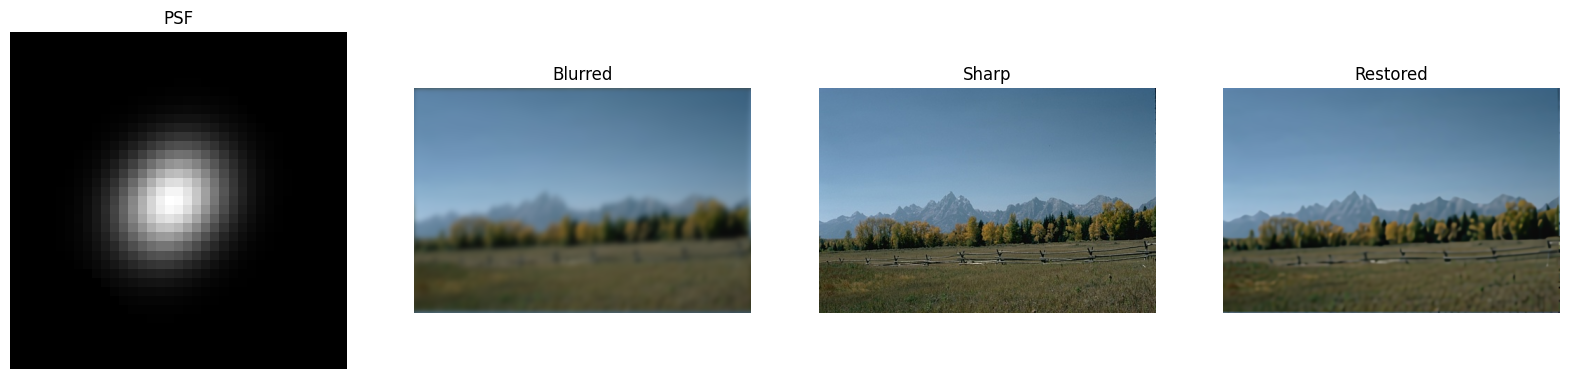

SSIM:  0.848319
PSNR:  26.971293795497676
MSE:  0.002008494378090562


In [14]:
restored = model.forward(blurred_tensor, psf)[0]

viz_res(psf=psf, sharp_image=image, blurred_image=blurred_tensor, restored_image=restored)

print('SSIM: ', ssim(image, restored, channel_axis=2))
print('PSNR: ', psnr(image, restored))
print('MSE: ', mse(image, restored))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


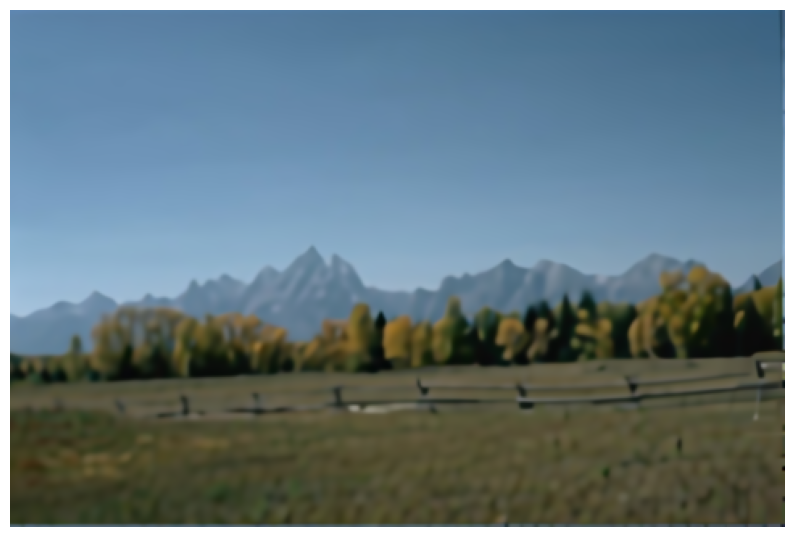

In [15]:
imshow(restored, figsize=(10, 10))